In [33]:
import operator
import random
import math
import copy
import matplotlib.pyplot as plt
from Cython import wraparound, boundscheck

import numpy as np
import pandas as pd
import cython.parallel as parallel

actual_theta = [0.7, 0.5, 0.4]

GREEDY_epsilon = [0.1, 0.5, 0.9]
UCB_c = [1, 5, 10]
TS_ab = [[[1, 1], [1, 1], [1, 1]],
         [[601, 401], [401, 601], [2, 3]]]

class Loader:
    def __init__(self, path):
        self.data=None
        self.table=None
        self.arm_num=None
        self.means=None
        self.optArm=None
        self.sampler=None
        self.range=None
        self.r_mid=None
        self.path=path
        self.load_data(path)

    def load_data(self,path):
        self.data=pd.read_csv(path)
        if 'arm1' in self.data.columns.values:
            self.load_data_gen()
        else:
            self.load_data_movie()

    def load_data_gen(self):
        path=self.path
        self.data = pd.read_csv(path)
        self.arm_num = self.data.columns.size
        self.range=self.data[self.data.columns[0]].max()-self.data[self.data.columns[0]].min()
        self.r_mid=float(self.data[self.data.columns[0]].max()+self.data[self.data.columns[0]].min())/2
        self.means = [0] * self.arm_num
        for i in range(self.arm_num):
            self.means[i] = self.data[self.data.columns[i]].mean()
        self.optArm = np.argmax(self.means)

        # 0,1,2,...
        self.table = np.zeros([self.arm_num, self.data.values.max() + 1, self.arm_num])
        for s_idx, source_arm in enumerate(self.data.columns):
            for a_idx, aim_arm in enumerate(self.data.columns):
                for i in range(self.data.values.max() + 1):
                    if source_arm == aim_arm:
                        self.table[s_idx][i][a_idx] = i
                    else:
                        p_reward = self.data[aim_arm][self.data[source_arm] == i].mean()
                        if p_reward > 1:
                            self.table[s_idx][i][a_idx] = 1
                        else:
                            self.table[s_idx][i][a_idx] = p_reward
        self.sampler=self.sample_gen

    def load_data_movie(self):
        #csv data
        self.arm_num=self.data['genre_col'].max()+1
        self.range=self.data['Rating'].max()-self.data['Rating'].min()
        self.r_mid=float(self.data[self.data.columns[0]].max()+self.data[self.data.columns[0]].min())/2
        self.means=[0]*self.arm_num
        for i in range(self.arm_num):
            self.means[i]=self.data[self.data['genre_col']==i]['Rating'].mean()
        self.optArm=np.argmax(self.means)
        #0,1,2,...
        self.table = np.zeros([self.arm_num, self.data['Rating'].max()-self.data['Rating'].min()+1, self.arm_num])
        for source in range(self.arm_num):
            for score in range(self.data['Rating'].min(),self.data['Rating'].max()+1):
                users=set(self.data[(self.data['genre_col'] == source) & (self.data['Rating'] == score)]['UserID'])
                self.table[source][:,source]=np.arange(self.data['Rating'].min(), self.data['Rating'].max() + 1)
                for aim in range(self.arm_num):
                    if aim==source:
                        continue
                    temp=self.data[self.data['genre_col'] == aim & self.data['UserID'].isin(users)]['Rating']
                    self.table[source][score-self.data['Rating'].min()][aim]=temp.mean()
        self.sampler =self.sample_movie

    def sample_movie(self,choose):
        v= self.data[self.data['genre_col'] == choose]['Rating'].sample(n=1, replace=True)
        return v.values[0]

    def sample_gen(self, choose):
        reward = self.data[self.data.columns[choose]].sample(n=1, replace=True)
        return reward.values[0]

class P1:

    def __init__(self, depend_data_path=None):
        self.path = depend_data_path
        self.greedy_regret = np.zeros(N+1)
        self.TS_regret = np.zeros(N+1)
        self.UCB_regret = np.zeros(N+1)
        self.dependent_UCB_regret = np.zeros(N+1)
        self.dependent_TS_regret = np.zeros(N+1)
        self.TS_Gauss_regret=np.zeros(N+1)

        if depend_data_path is not None:
            self.loader=Loader(depend_data_path)
            self.actual_theta=self.loader.means
            self.optArm=self.loader.optArm
            self.arm_num=self.loader.arm_num
            self.sampler=self.loader.sampler
            self.table=self.loader.table
            self.range=self.loader.range
            self.r_mid=self.loader.r_mid
        else:
            self.loader=None
            self.table=None
            self.range = 1
            self.r_mid=0.5
            self.actual_theta=actual_theta
            self.optArm=np.argmax(self.actual_theta)
            self.arm_num = len(self.actual_theta)
            self.sampler=self.independ_reward

    def independ_reward(self, choose):
        # choose: 1,2,3
        probability = self.actual_theta[choose]
        if random.uniform(0, 1) < probability:
            return 1
        else:
            return 0

    def e_Greedy(self, N, epsilon):
        # initialize
        # Notice we set index start from 1
        theta = [0]*self.arm_num
        count =[0]*self.arm_num
        total_reward = 0
        greedy_current_regret = np.zeros(N+1)

        for t in range(N):
            # I_t=1,2,3...
            if random.uniform(0, 1) < epsilon:
                I_t = random.randint(0, self.arm_num-1)
            else:
                I_t = np.argmax(theta)

            count[I_t] += 1
            r = self.sampler(I_t)
            total_reward += r
            theta[I_t] += (1 / count[I_t]) * (r - theta[I_t])
            if t==0:
                greedy_current_regret[t+1] = self.actual_theta[self.optArm] - self.actual_theta[I_t]
            else:
                greedy_current_regret[t+1] = greedy_current_regret[t] + self.actual_theta[self.optArm] - self.actual_theta[I_t]

        self.greedy_regret += greedy_current_regret
        return total_reward

    def Ucb(self, N, c):
        # note the index start from 0
        count = [0]* self.arm_num
        theta = [0]* self.arm_num
        total_reward = 0
        UCB_current_regret = np.zeros(N+1)

        # initialize
        for t in range(self.arm_num):
            I_t = t
            count[I_t] = 1
            theta[I_t] = self.sampler(I_t)
            if t==0:
                UCB_current_regret[t] = self.actual_theta[self.optArm] - self.actual_theta[I_t]
            else:
                UCB_current_regret[t] = UCB_current_regret[t-1] + actual_theta[self.optArm] - actual_theta[I_t]

        for t in range(self.arm_num, N):
            # select and pull arm
            I_t =np.argmax([theta[j] + c * math.sqrt(2 * math.log(t) / count[j]) for j in range(self.arm_num)])

            count[I_t] += 1
            r = self.sampler(I_t)
            total_reward += r
            theta[I_t] += (r - theta[I_t]) / count[I_t]
            UCB_current_regret[t+1] = UCB_current_regret[t] + self.actual_theta[self.optArm] - self.actual_theta[I_t]

        self.UCB_regret += UCB_current_regret
        return total_reward

    def depend_Ucb(self, N, c):
        table=self.table
        arm_num=self.arm_num

        count = np.array([0]*arm_num)
        theta = np.array([0.]*arm_num)
        ucb_idx=dict(zip(range(arm_num),[np.inf]*arm_num))
        ave_pseudo_reward=np.array([[np.inf]*arm_num]*arm_num)
        sum_pseudo_reward=np.array([[0.]*arm_num]*arm_num)
        d_UCB_current_regret = np.zeros(N+1)

        total_reward = 0
        for t in range(N):
            if t<arm_num:
                choose=t
            else:
                S_bool=(count>=(float(t-1)/arm_num))
                k_emp_reward=np.max(theta[S_bool])
                k_emp=np.where(theta==k_emp_reward)[0][0]
                comp_set=set()
                comp_set.add(k_emp)
                min_phi = np.min(ave_pseudo_reward[:, S_bool], axis=1)
                for k in range(arm_num):
                    if min_phi[k]>= k_emp_reward:
                        comp_set.add(k)

                comp_idx={ind: ucb_idx[ind] for ind in comp_set}
                choose=max(comp_idx.items(),key=operator.itemgetter(1))[0]
            # print(t,choose)
            if t==0:
                d_UCB_current_regret[t+1] = self.actual_theta[self.optArm] - self.actual_theta[choose]
            else:
                d_UCB_current_regret[t+1] = d_UCB_current_regret[t] + self.actual_theta[self.optArm] - self.actual_theta[choose]

            reward=self.sampler(choose)
            count[choose]+=1
            theta[choose]+=((reward-theta[choose])/count[choose])

            for arm in range(arm_num):
                if (count[arm] > 0):
                    ucb_idx[arm] = theta[arm] + c * np.sqrt(2 * np.log(t + 1) / count[arm])

            # pseudoReward=table[choose][reward]
            pseudoReward = table[choose][reward - 1,:]
            sum_pseudo_reward[:, choose] = sum_pseudo_reward[:, choose]+ pseudoReward
            ave_pseudo_reward[:, choose] = np.divide(sum_pseudo_reward[:, choose], count[choose])

            ave_pseudo_reward[np.arange(arm_num),np.arange(arm_num)]=theta

            total_reward+=reward

        self.dependent_UCB_regret += d_UCB_current_regret
        return total_reward

    def TS_sample_Gauss(self,theta,count,beta):
        std=np.sqrt(float(beta)/(count+1))
        return np.random.normal(theta,std)


    def TS_arm_choose_beta(self, ab):
        theta = [0 for i in ab]
        for i, (a, b) in enumerate(ab):
            theta[i] = np.random.beta(a, b)
        return np.argmax(theta)

    def TS(self, N, ab_original):

        total_reward = 0
        # ab idx start from 0
        ab = copy.deepcopy(ab_original)
        TS_current_regret = np.zeros(N+1)
        for t in range(N):
            I_t = self.TS_arm_choose_beta(ab)
            # print(I_t)
            # update distribution
            r = self.sampler(I_t)
            ab[I_t][0] += r
            ab[I_t][1] += (1 - r)
            total_reward += r
            if t==0:
                TS_current_regret[t+1] = self.actual_theta[self.optArm] - self.actual_theta[I_t]
            else:
                TS_current_regret[t+1] = TS_current_regret[t] + self.actual_theta[self.optArm] - self.actual_theta[I_t]
        # compute the expectation!!
        # result = []
        # for j in arms:
        #     result.append(ab[j - 1][0] / (ab[j - 1][0] + ab[j - 1][1]))
        # print(choose_first_cluster)

        self.TS_regret += TS_current_regret
        return total_reward

    def TS_Gauss(self, N, beta):
        arm_num=self.arm_num
        total_reward = 0
        # ab idx start from 0
        TS_G_current_regret = np.zeros(N + 1)
        theta = np.array([self.r_mid] * arm_num)
        count = np.array([0] * arm_num)
        for t in range(N):
            I_t=np.argmax(self.TS_sample_Gauss(theta,count,beta))
            # print(I_t)
            # update distribution
            r = self.sampler(I_t)
            count[I_t] += 1
            theta[I_t] += ((r - theta[I_t]) / count[I_t])
            total_reward += r
            if t==0:
                TS_G_current_regret[t+1] = self.actual_theta[self.optArm] - self.actual_theta[I_t]
            else:
                TS_G_current_regret[t+1] = TS_G_current_regret[t] + self.actual_theta[self.optArm] - self.actual_theta[I_t]
        # compute the expectation!!
        # result = []
        # for j in arms:
        #     result.append(ab[j - 1][0] / (ab[j - 1][0] + ab[j - 1][1]))
        # print(choose_first_cluster)

        self.TS_Gauss_regret += TS_G_current_regret
        return total_reward

    # TODO
    def depend_TS(self, N, beta):
        table = self.table
        arm_num = self.arm_num

        theta = np.array([self.r_mid] * arm_num)
        count = np.array([0] * arm_num)

        ave_pseudo_reward = np.array([[np.inf] * arm_num] * arm_num)
        sum_pseudo_reward = np.array([[0.] * arm_num] * arm_num)
        d_TS_current_regret = np.zeros(N + 1)

        total_reward = 0
        for t in range(N):
            if t<arm_num:
                choose=t
            else:
                S_bool = (count >= (float(t - 1) / arm_num))

                k_emp_reward = np.max(theta[S_bool])
                k_emp = np.where(theta == k_emp_reward)[0][0]
                comp_set = set()
                comp_set.add(k_emp)
                min_phi = np.min(ave_pseudo_reward[:, S_bool], axis=1)
                for k in range(arm_num):
                    if min_phi[k] >= k_emp_reward:
                        comp_set.add(k)

                sample=self.TS_sample_Gauss(theta,count,beta)
                comp_idx = {ind: sample[ind] for ind in comp_set}
                choose = max(comp_idx.items(), key=operator.itemgetter(1))[0]
            # print(t,choose)
            if t == 0:
                d_TS_current_regret[t + 1] = self.actual_theta[self.optArm] - self.actual_theta[choose]
            else:
                d_TS_current_regret[t + 1] = d_TS_current_regret[t] + self.actual_theta[self.optArm] - \
                                              self.actual_theta[choose]

            reward = self.sampler(choose)
            count[choose] += 1
            theta[choose] += ((reward - theta[choose]) / count[choose])

            # pseudoReward=table[choose][reward]
            pseudoReward = table[choose][reward - 1, :]
            sum_pseudo_reward[:, choose] = sum_pseudo_reward[:, choose] + pseudoReward
            ave_pseudo_reward[:, choose] = np.divide(sum_pseudo_reward[:, choose], count[choose])

            ave_pseudo_reward[np.arange(arm_num), np.arange(arm_num)] = theta

            total_reward += reward

        self.dependent_TS_regret += d_TS_current_regret
        return total_reward

    @boundscheck(False)
    @wraparound(False)
    def result(self, function_idx):
        function = ['epsilon-greedy', 'UCB', 'TS', 'D-UCB','TS-Gauss', 'D-TS']
        print("results for", function[function_idx - 1], "Algorithm:")
        para = []
        func = None

        if function_idx == 1:
            para = GREEDY_epsilon
            func = self.e_Greedy
            parameter = "epsilon"
            regret=self.greedy_regret
        elif function_idx == 2:
            para = UCB_c
            func = self.Ucb
            parameter = "c"
            regret=self.UCB_regret
        elif function_idx == 3:
            para = TS_ab
            func = self.TS
            parameter = "a,b"
            regret=self.TS_regret
        elif function_idx == 4:
            para = UCB_c
            func = self.depend_Ucb
            parameter = "c"
            regret=self.dependent_UCB_regret
        elif function_idx == 5:
            para = [self.range/2]
            func = self.TS_Gauss
            parameter = "Beta"
            regret=self.TS_Gauss_regret
        elif function_idx == 6:
            para = [self.range/2]
            func = self.depend_TS
            parameter = "Beta"
            regret=self.dependent_TS_regret

        regret.fill(0.)
        for p in para:
            result = 0.0
            for trial in parallel.prange(trial_times, nogil=True,schedule="static", chunksize=1):
                result += func(N, p)
            result /= trial_times
            print(result, "with parameter", parameter, "as", p)
        regret /= (trial_times * len(para))

In [30]:
print("Independent part")
trial_times = 200
N = 5000
p1=P1()
p1.result(1)
p1.result(2)
p1.result(3)

Independent part
results for epsilon-greedy Algorithm:
3410.665 with parameter epsilon as 0.1
3077.735 with parameter epsilon as 0.5
2747.34 with parameter epsilon as 0.9
results for UCB Algorithm:
3409.025 with parameter c as 1
2981.28 with parameter c as 5
2823.42 with parameter c as 10
results for TS Algorithm:
3477.665 with parameter a,b as [[1, 1], [1, 1], [1, 1]]
3491.06 with parameter a,b as [[601, 401], [401, 601], [2, 3]]


In [34]:
print("Dependent part")
trial_times = 50
N = 1000
# p1_d = P1('movie_3.csv')
# p1_d = P1('movie_18.csv')
p1_d=P1('dependent_data.csv')
p1_d.result(1)
p1_d.result(2)
p1_d.result(3)
p1_d.result(4)
p1_d.result(5)
p1_d.result(6)

Dependent part
results for epsilon-greedy Algorithm:
687.38 with parameter epsilon as 0.1
615.66 with parameter epsilon as 0.5
550.26 with parameter epsilon as 0.9
results for UCB Algorithm:
657.72 with parameter c as 1
569.44 with parameter c as 5
550.28 with parameter c as 10
results for TS Algorithm:
691.44 with parameter a,b as [[1, 1], [1, 1], [1, 1]]
699.78 with parameter a,b as [[601, 401], [401, 601], [2, 3]]
results for D-UCB Algorithm:
703.4 with parameter c as 1
703.64 with parameter c as 5
702.26 with parameter c as 10
results for TS-Gauss Algorithm:
685.08 with parameter Beta as 0.5
results for D-TS Algorithm:
699.3 with parameter Beta as 0.5


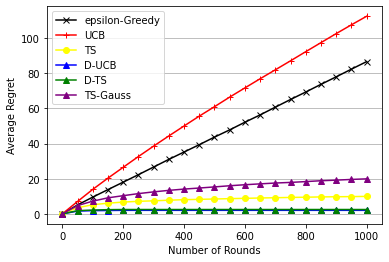

In [35]:
# plot
spacing = int(N/20)
plt.plot(range(0, N+1)[::spacing], p1_d.greedy_regret[::spacing], label='epsilon-Greedy', color='black', marker='x')
plt.plot(range(0, N+1)[::spacing], p1_d.UCB_regret[::spacing], label='UCB', color='red', marker='+')
plt.plot(range(0, N+1)[::spacing], p1_d.TS_regret[::spacing], label='TS', color='yellow', marker='o')
plt.plot(range(0, N+1)[::spacing], p1_d.dependent_UCB_regret[::spacing], label='D-UCB', color='blue', marker='^')
plt.plot(range(0, N+1)[::spacing], p1_d.dependent_TS_regret[::spacing], label='D-TS', color='green', marker='^')
plt.plot(range(0, N+1)[::spacing], p1_d.TS_Gauss_regret[::spacing], label='TS-Gauss', color='purple', marker='^')
plt.legend()
plt.grid(True, axis='y')
plt.xlabel('Number of Rounds')
plt.ylabel('Average Regret')
plt.show()